# CRE/MF Mortgage Rate Model On-ValidMind

# Setup

In [1]:
# Quick hack to load local library code
import os
os.chdir(os.path.join(os.getcwd(), ".."))
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

# ML libraries
import pandas as pd
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# ValidMind libraries 
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import validmind as vm
from validmind.vm_models.test_context import TestContext

# Plotting libraries 
import matplotlib.pyplot as plt
%matplotlib inline


# Load Data

In [2]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)
df.head()

,loan_rate_A,loan_rate_B,loan_rate_C,loan_rate_D,FEDFUNDS,diff1_loan_rate_A,diff1_loan_rate_B,diff1_loan_rate_C,diff1_loan_rate_D,diff1_FEDFUNDS,diff2_FEDFUNDS
Date,,,,,,,,,,,
2007-08-01,7.766667,9.497692,10.947500,12.267000,5.02,0.060000,0.134359,0.207500,-0.467444,-0.24,-0.25
2007-09-01,7.841429,9.276667,10.829167,12.436667,4.94,0.074762,-0.221026,-0.118333,0.169667,-0.08,0.16
2007-10-01,7.830000,9.433333,10.825926,12.737368,4.76,-0.011429,0.156667,-0.003241,0.300702,-0.18,-0.10
2007-11-01,7.779091,9.467778,10.967037,12.609444,4.49,-0.050909,0.034444,0.141111,-0.127924,-0.27,-0.09
2007-12-01,7.695833,9.387500,10.805000,12.478889,4.24,-0.083258,-0.080278,-0.162037,-0.130556,-0.25,0.02


Visual Inspection.

# ValidMind Setup

Initialize ValidMind dataset.

In [3]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgo0g0rt0000fjy6ozl9pb69"
)

True

In [4]:
target_variables = ["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column = target_variables   
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Create Train and Test datasets.

In [5]:
test_size = 30
train_ds = df[:-test_size]
test_ds = df[-test_size:]

vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column=target_variables)
vm_test_ds = vm.init_dataset(dataset=test_ds, type="generic", target_column=target_variables)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


Visualize existing test plans.

In [6]:
vm.test_plans.list_plans()

ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.
unit_root_test_plan,UnitRootTestPlan,Test plan to perform unit root tests.


# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

## A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

**Step 2: Display the missing values percentage in a table format**

**Step 3: Visualize the missing values**

 ## B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

**Step 2: Calculate Z-scores**

**Step 3: Set a threshold and identify outliers**

Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

**Step 4: Analyze the outliers**

Analyze the outliers by looking at their frequency, index, and corresponding column.

## C. Seasonality Analysis

**Step 1: Seasonal decomposition**

Perform seasonal decomposition on each time series.

In [7]:
from validmind.model_validation.statsmodels.metrics import SeasonalDecomposeMetricWithFigure
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecomposeMetricWithFigure(test_context=test_context)
sd_metric.run()

TestPlanMetricResult(figures=[Figure(key='seasonal_decomposition_with_figure', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=MetricResult(type='evaluation', scope='', key='seasonal_decomposition_with_figure', value={'loan_rate_A': [{'date': '2007-08-01', 'trend': nan, 'seasonal': -0.050284773390468294, 'resid': nan, 'observed': 7.7666666666666675}, {'date': '2007-09-01', 'trend': nan, 'seasonal': -0.06087962072801919, 'resid': nan, 'observed': 7.841428571428572}, {'date': '2007-10-01', 'trend': nan, 'seasonal': 0.01749661199350142, 'resid': nan, 'observed': 7.83}, {'date': '2007-11-01', 'trend': nan, 'seasonal': -0.047258378330469496, 'resid': nan, 'observed': 7.779090909090908}, {'date': '2007-12-01', 'trend': nan, 'seasonal': 0.0850517814632488, 'resid': nan, 'observed': 7.695833333333333}, {'date': '2008-01-01', 'trend': nan, 'seasonal': 0.06564185816692857, 'resid': nan, 'observed': 7.961333333333333}, {'date': '2008-02-01', 'trend': 8.0050487679590

**Step 2: Visualize seasonal decomposition**

Create plots for observed, trend, seasonal and residual components.


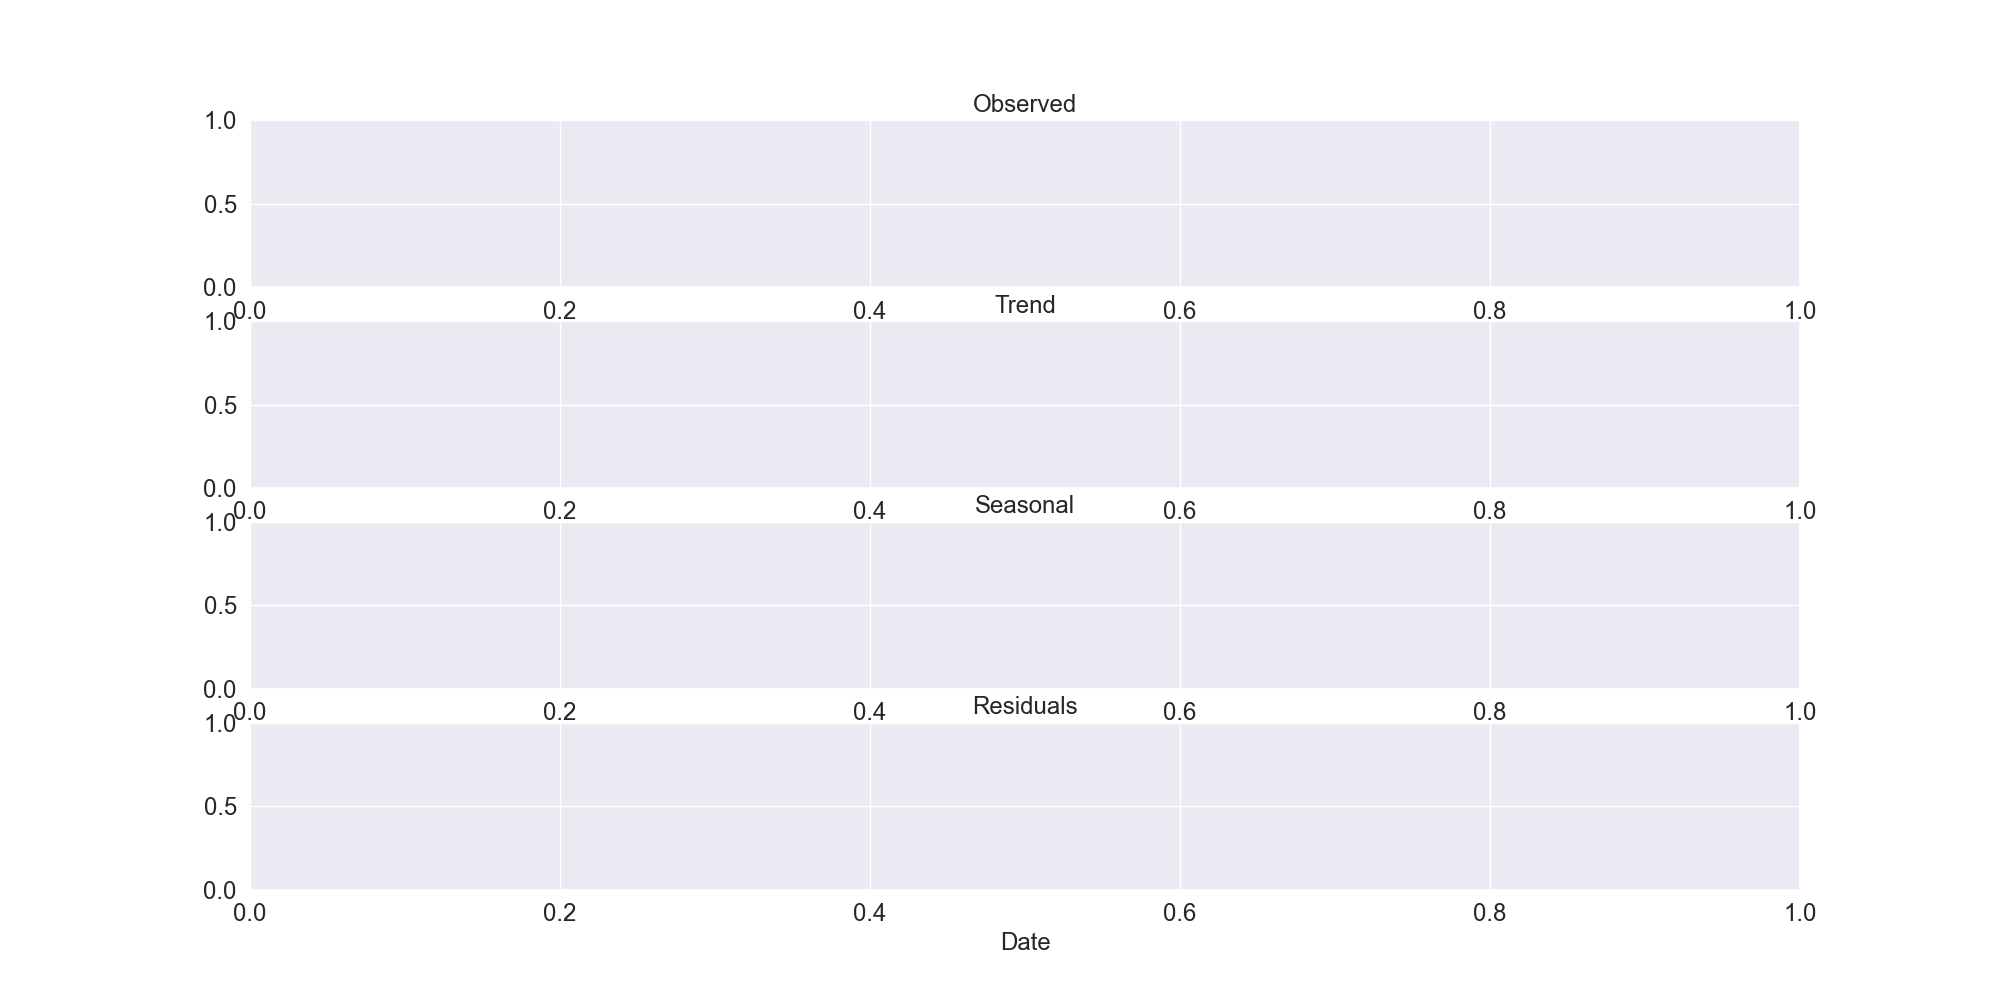

In [8]:
sd_metric.result.show()

Create ACF plots for all variables.

**Step 3: Residuals Analysis**

Residuals series, histogram, Q-Q and ACF plots.

In [9]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
from validmind.model_validation.statsmodels.metrics import ResidualsVisualInspection
test_context = TestContext(train_ds=vm_train_ds)
rvi_metric = ResidualsVisualInspection(test_context=test_context)
rvi_metric.run()

TestPlanMetricResult(figures=[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None), Figure(key='residuals_visual_inspection', metadata={}, figure=<Fig


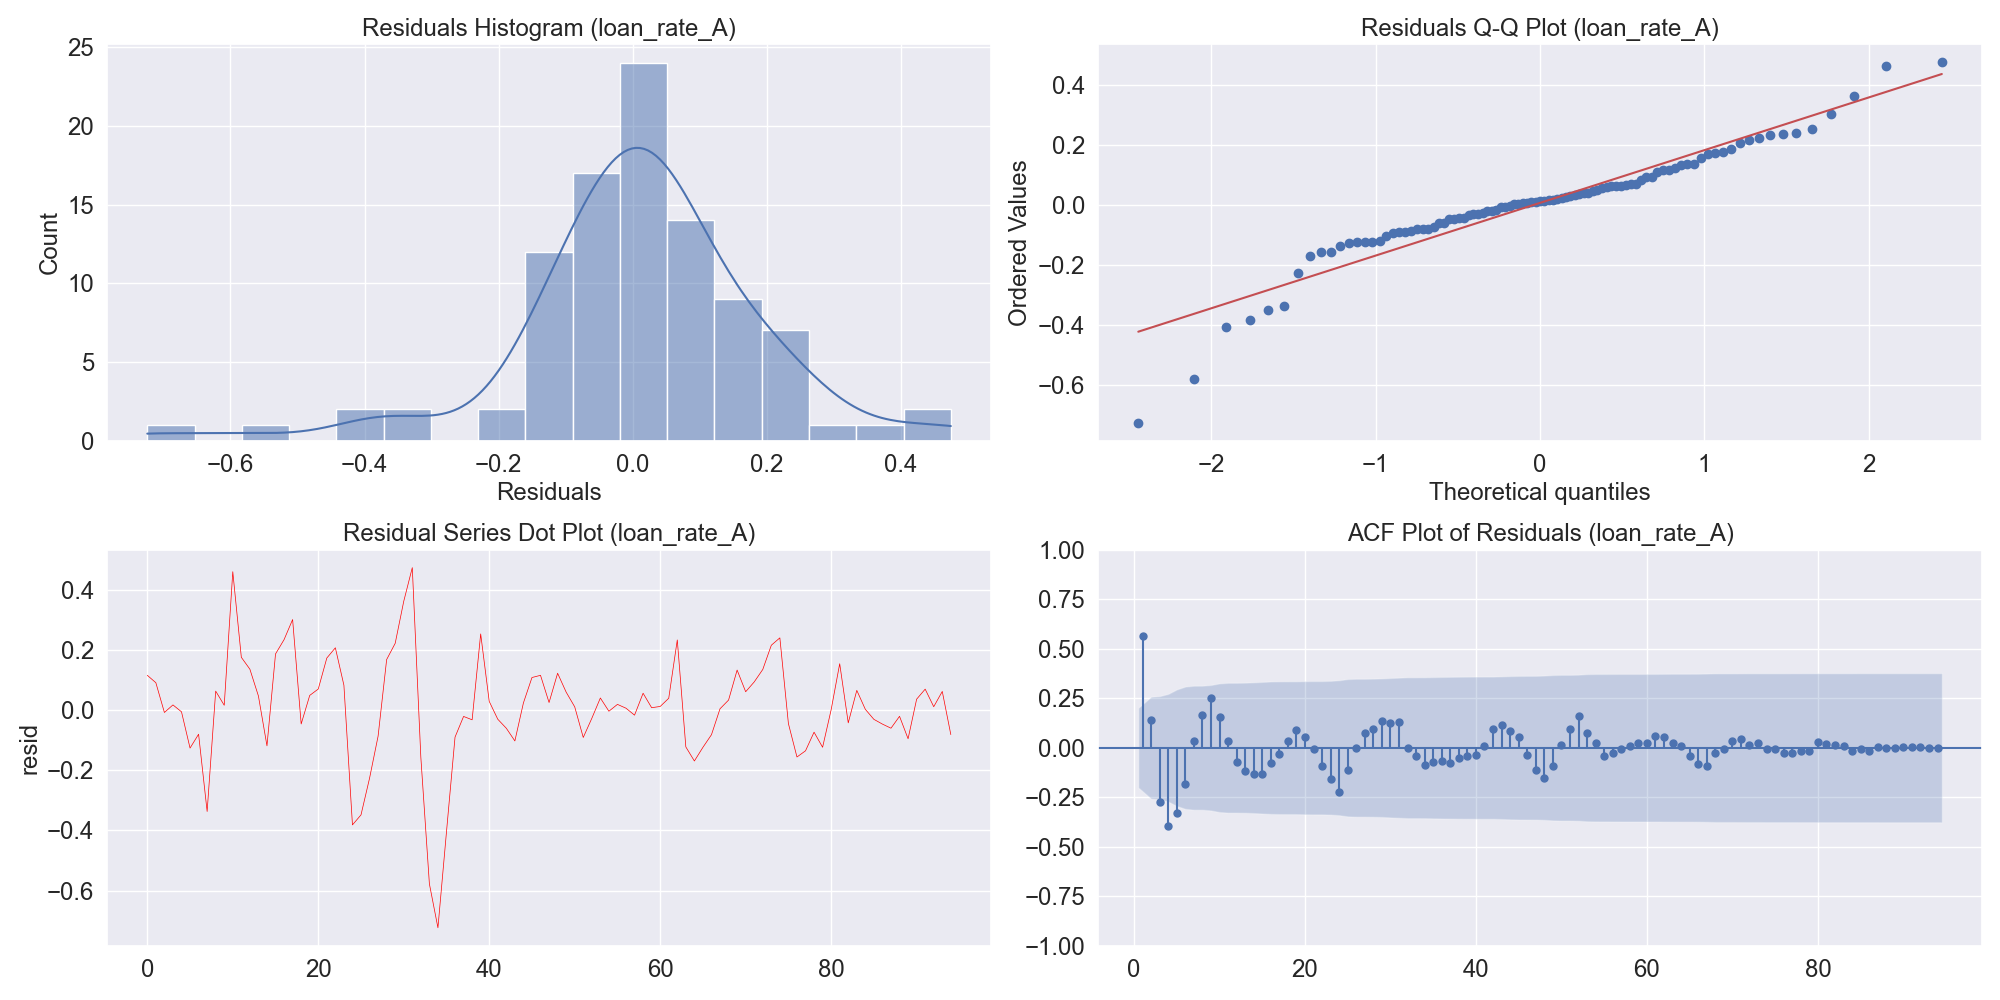
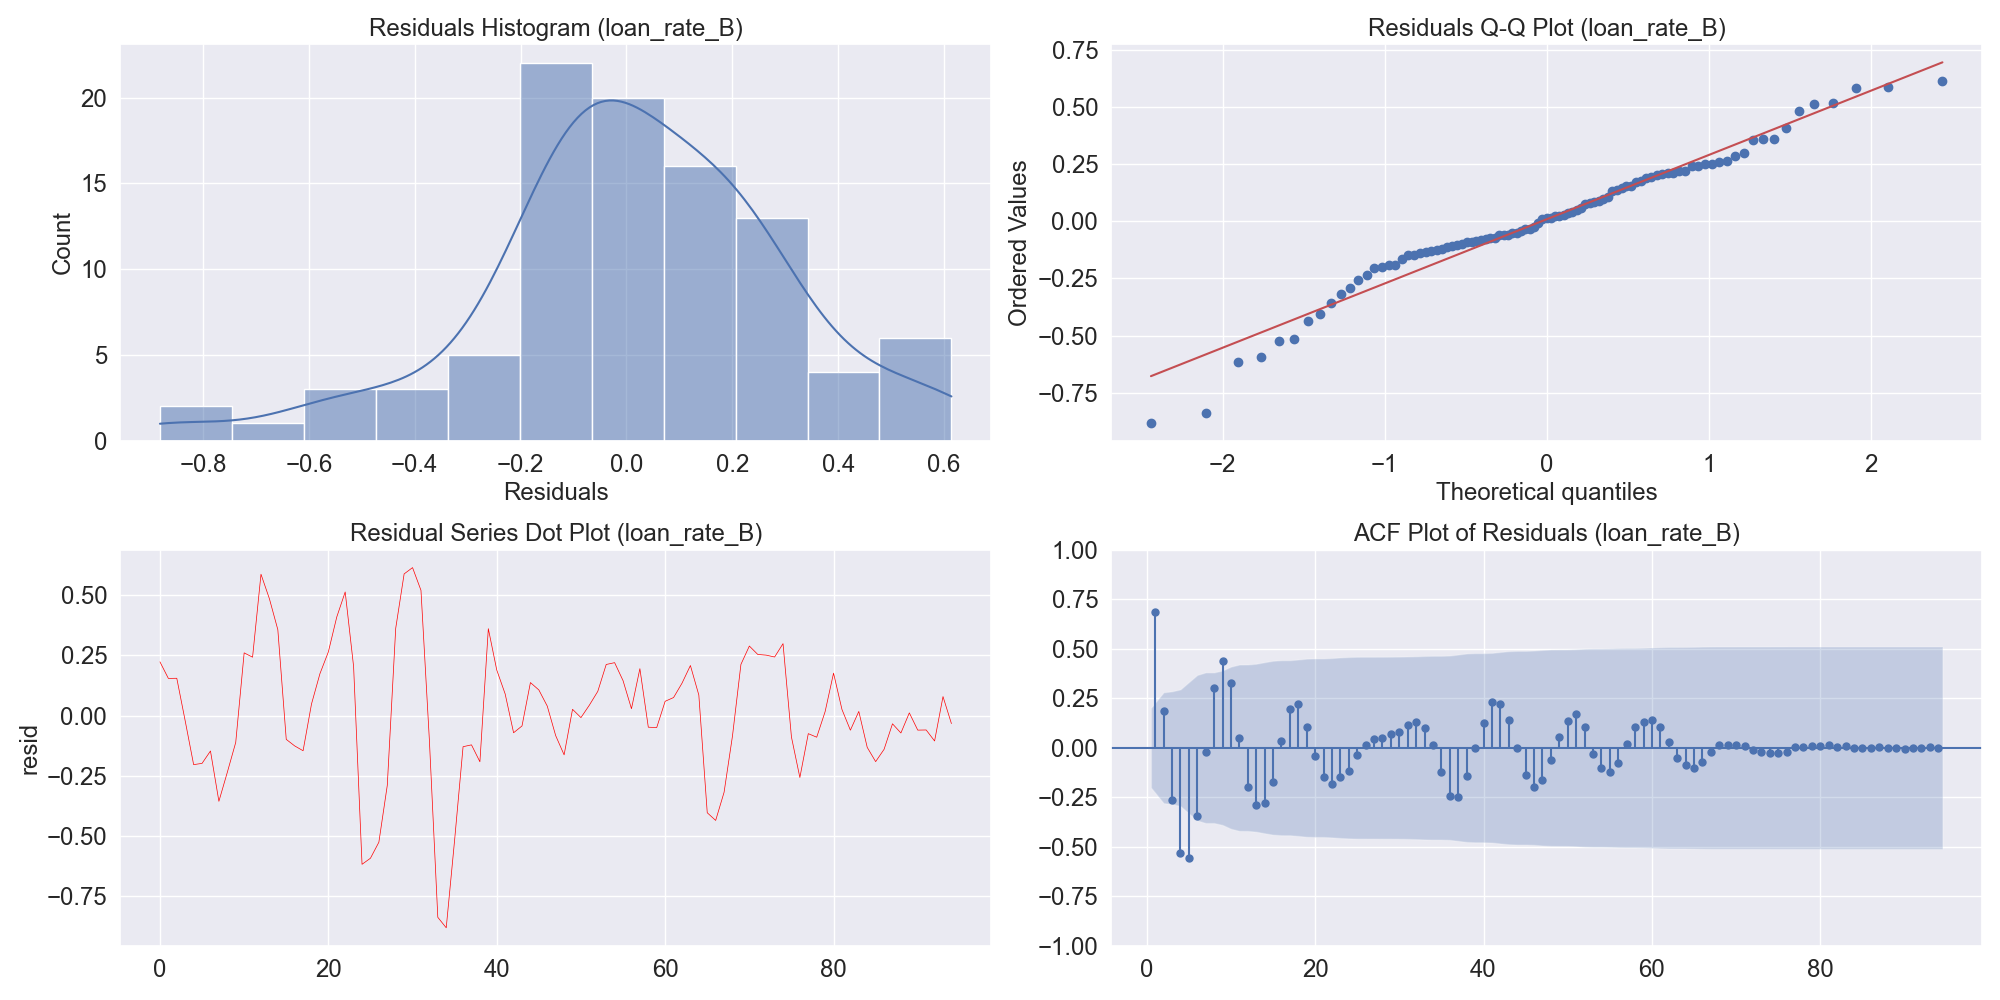
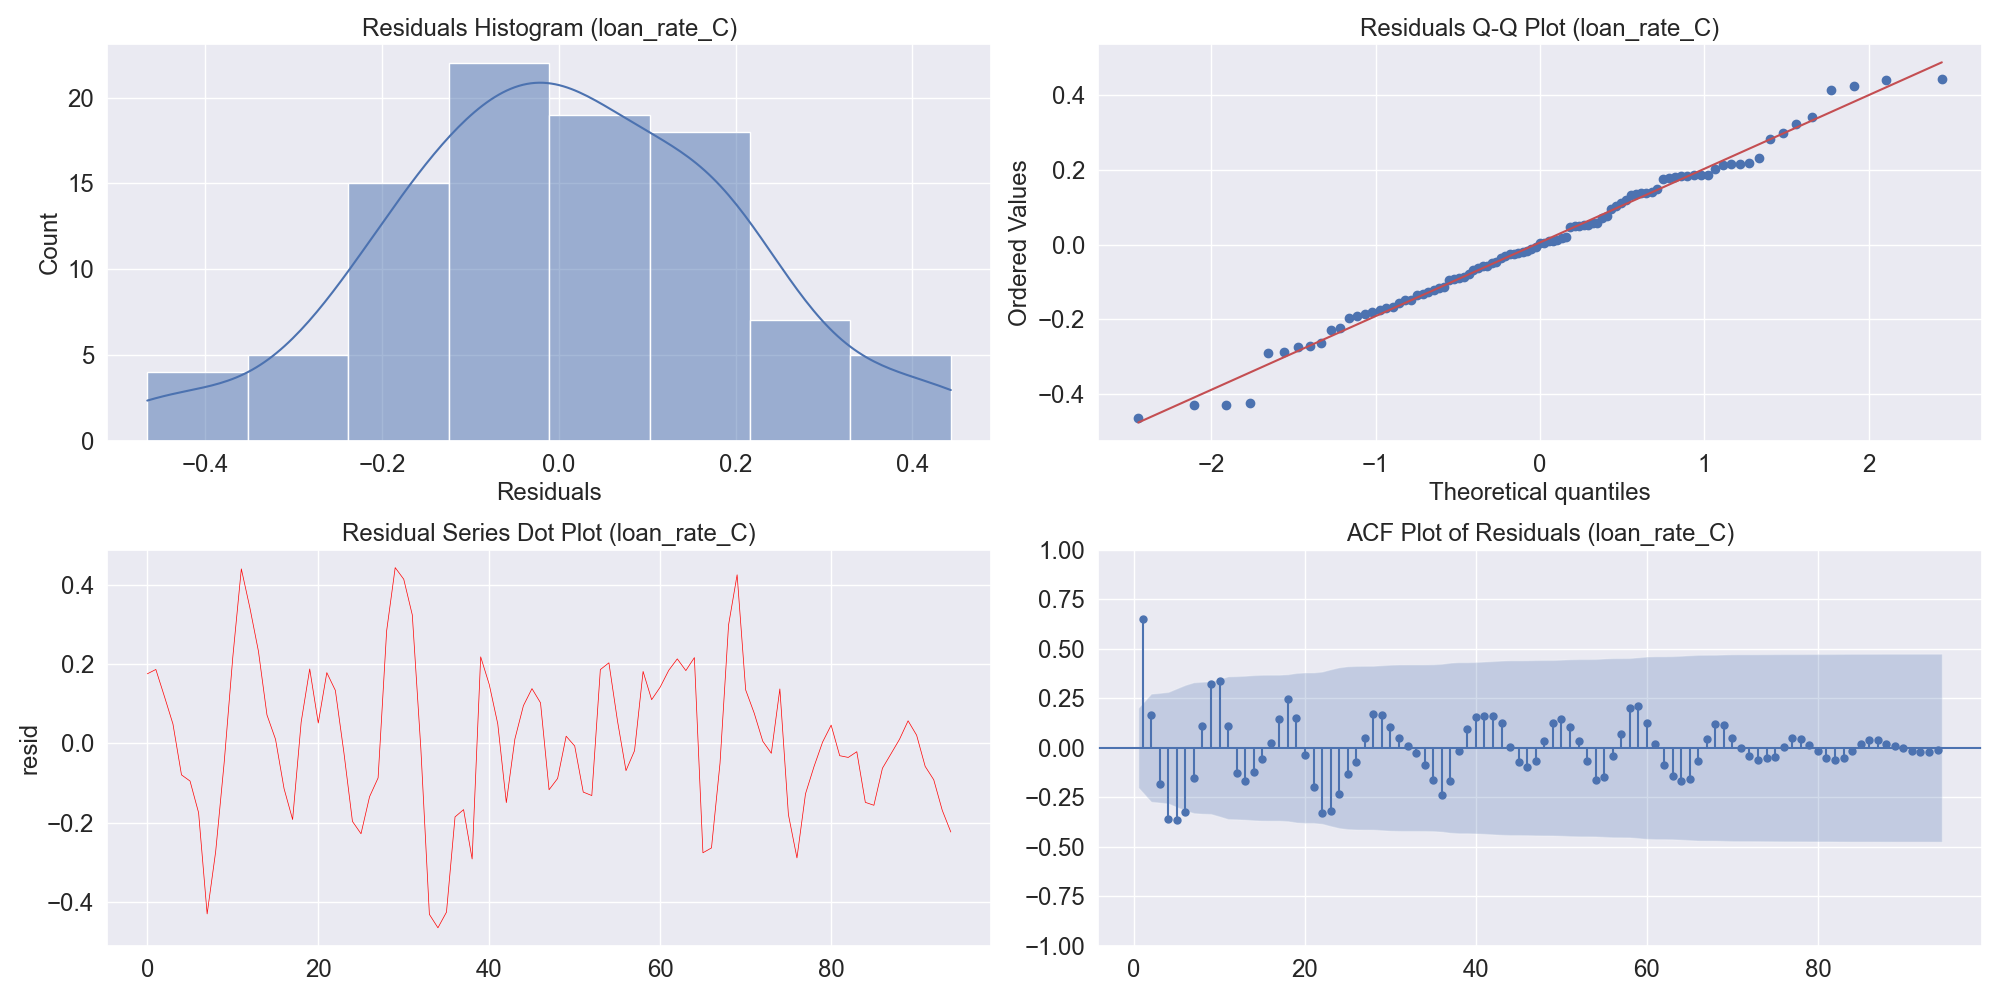
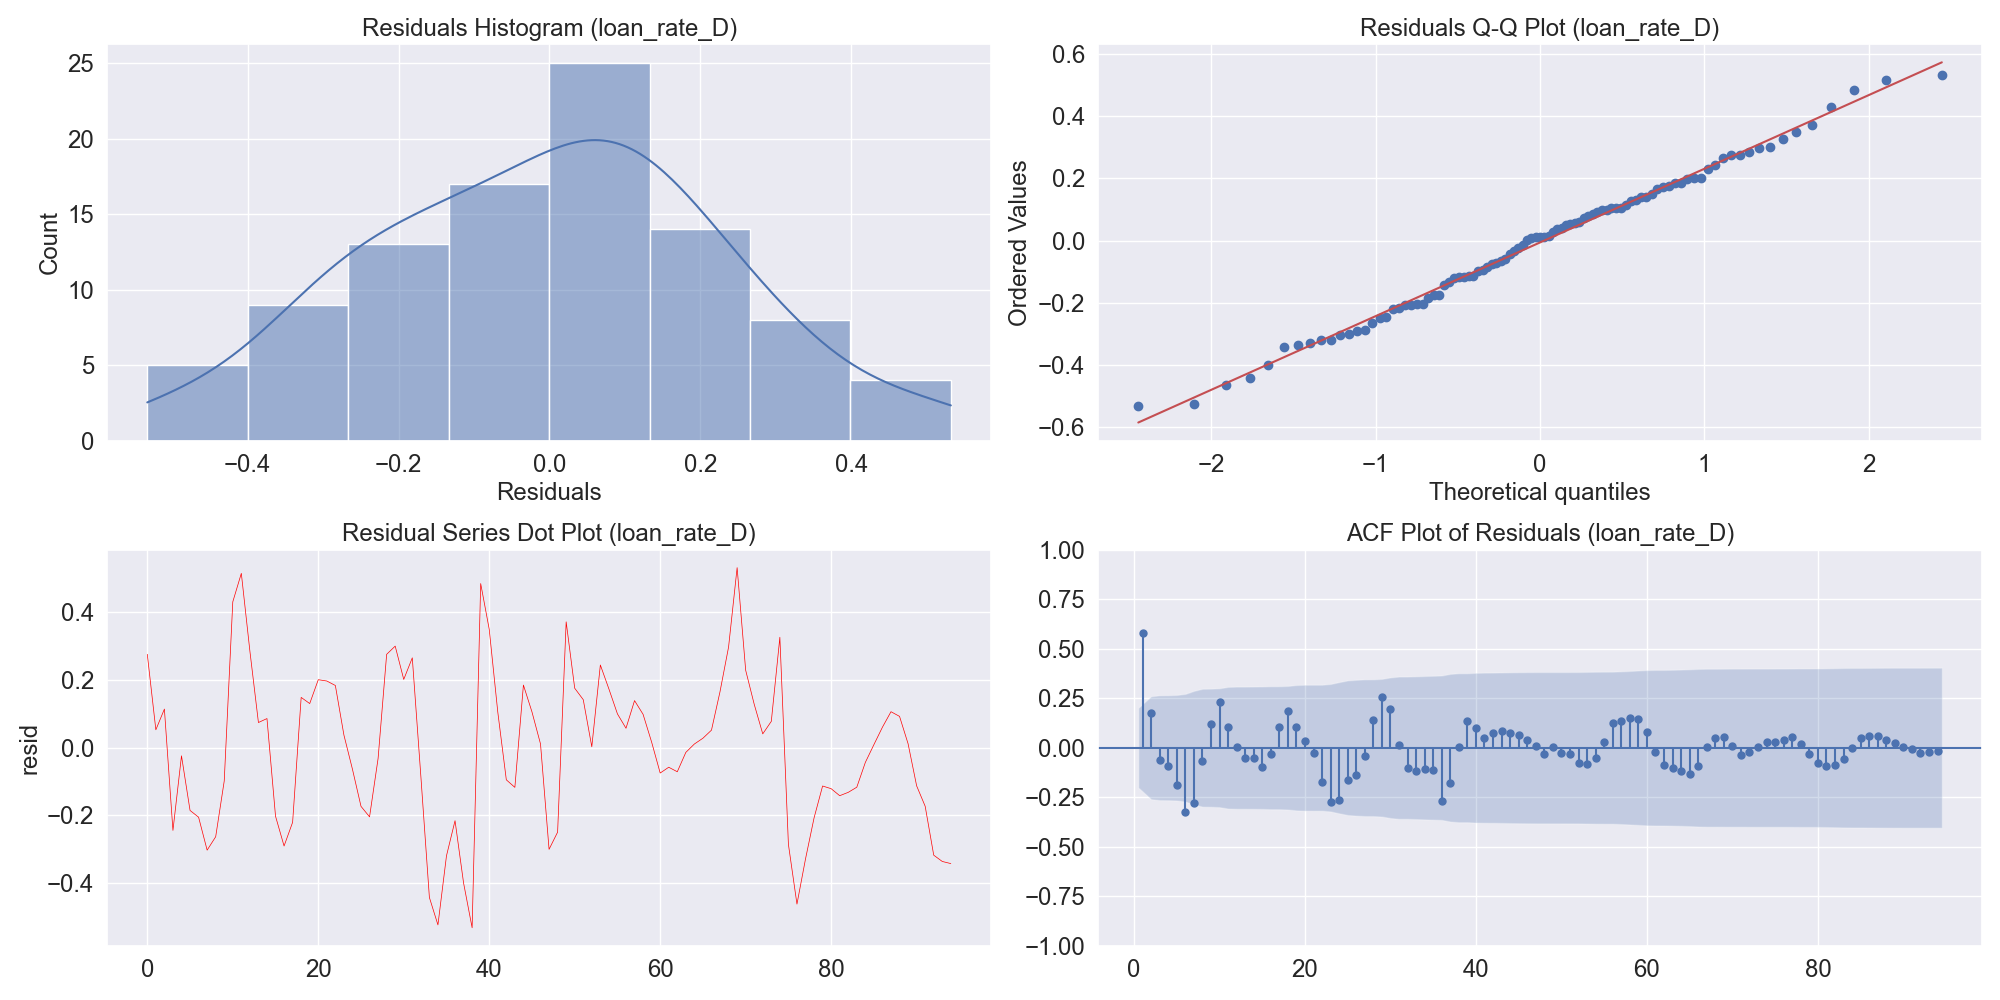
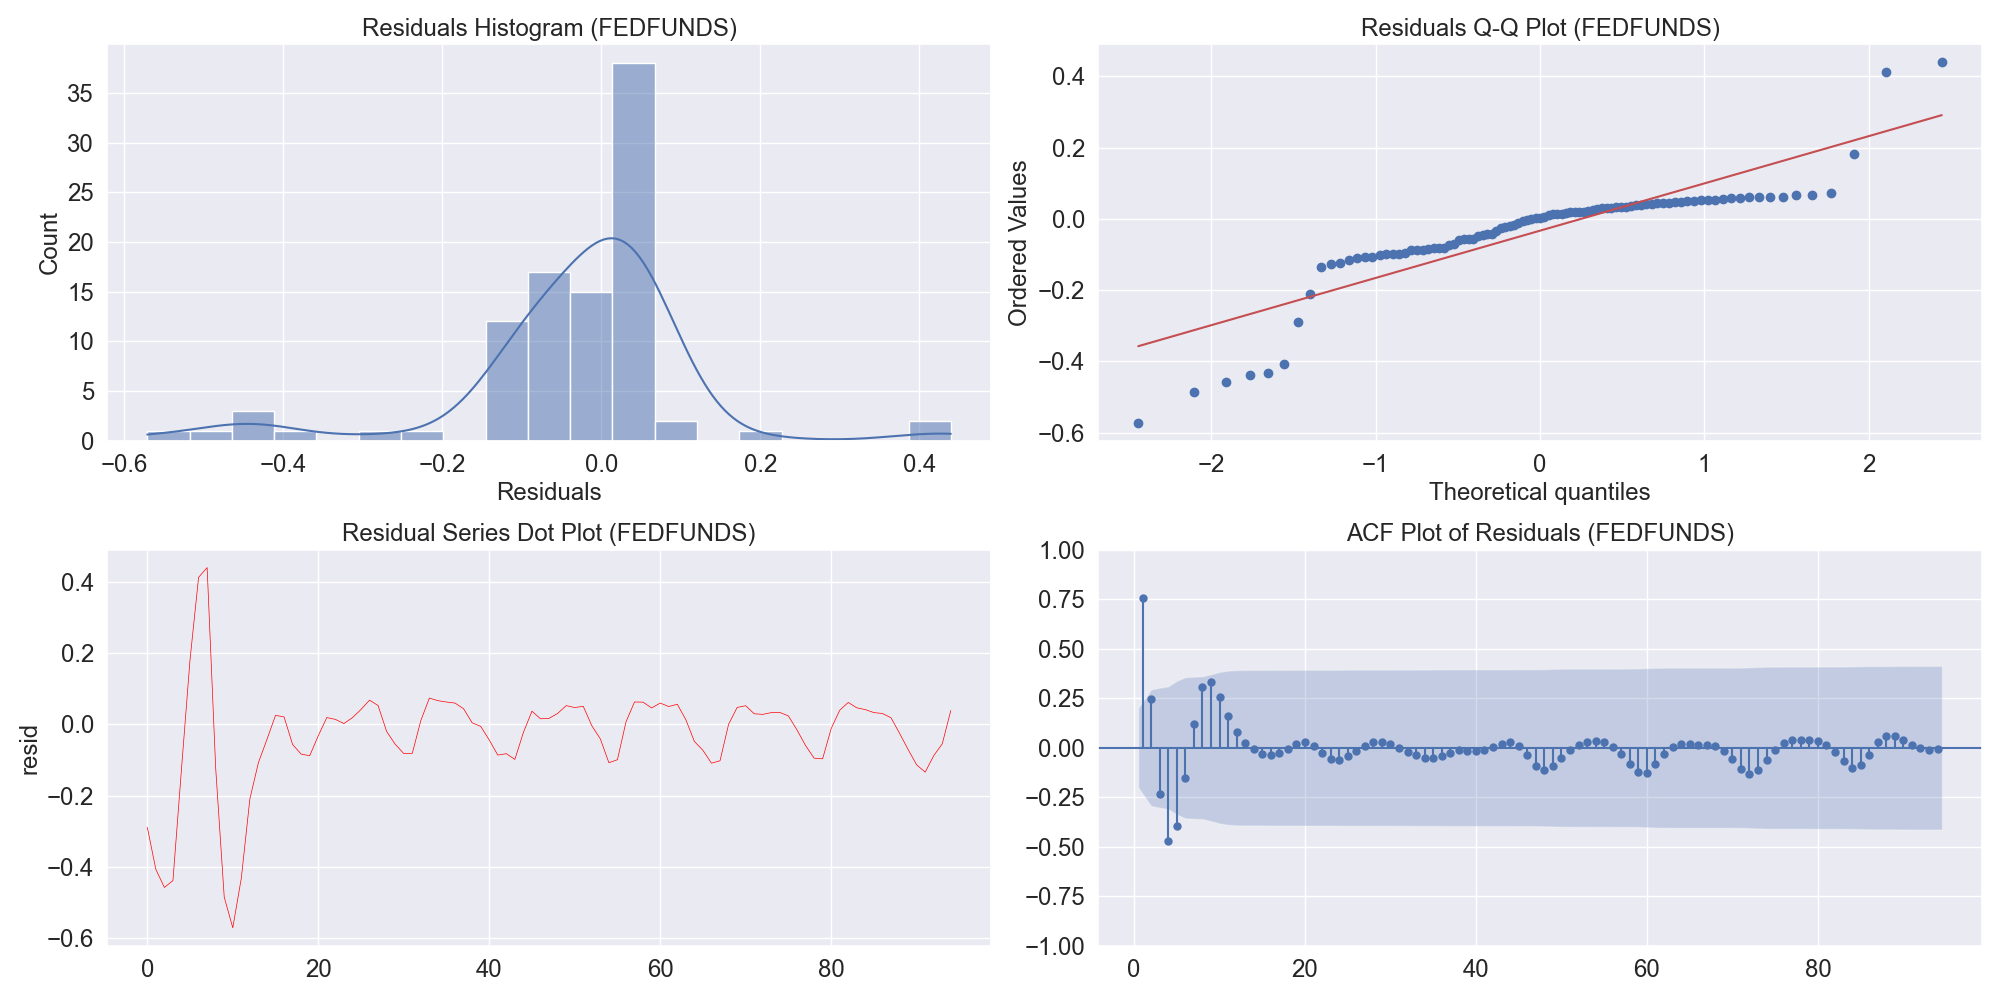
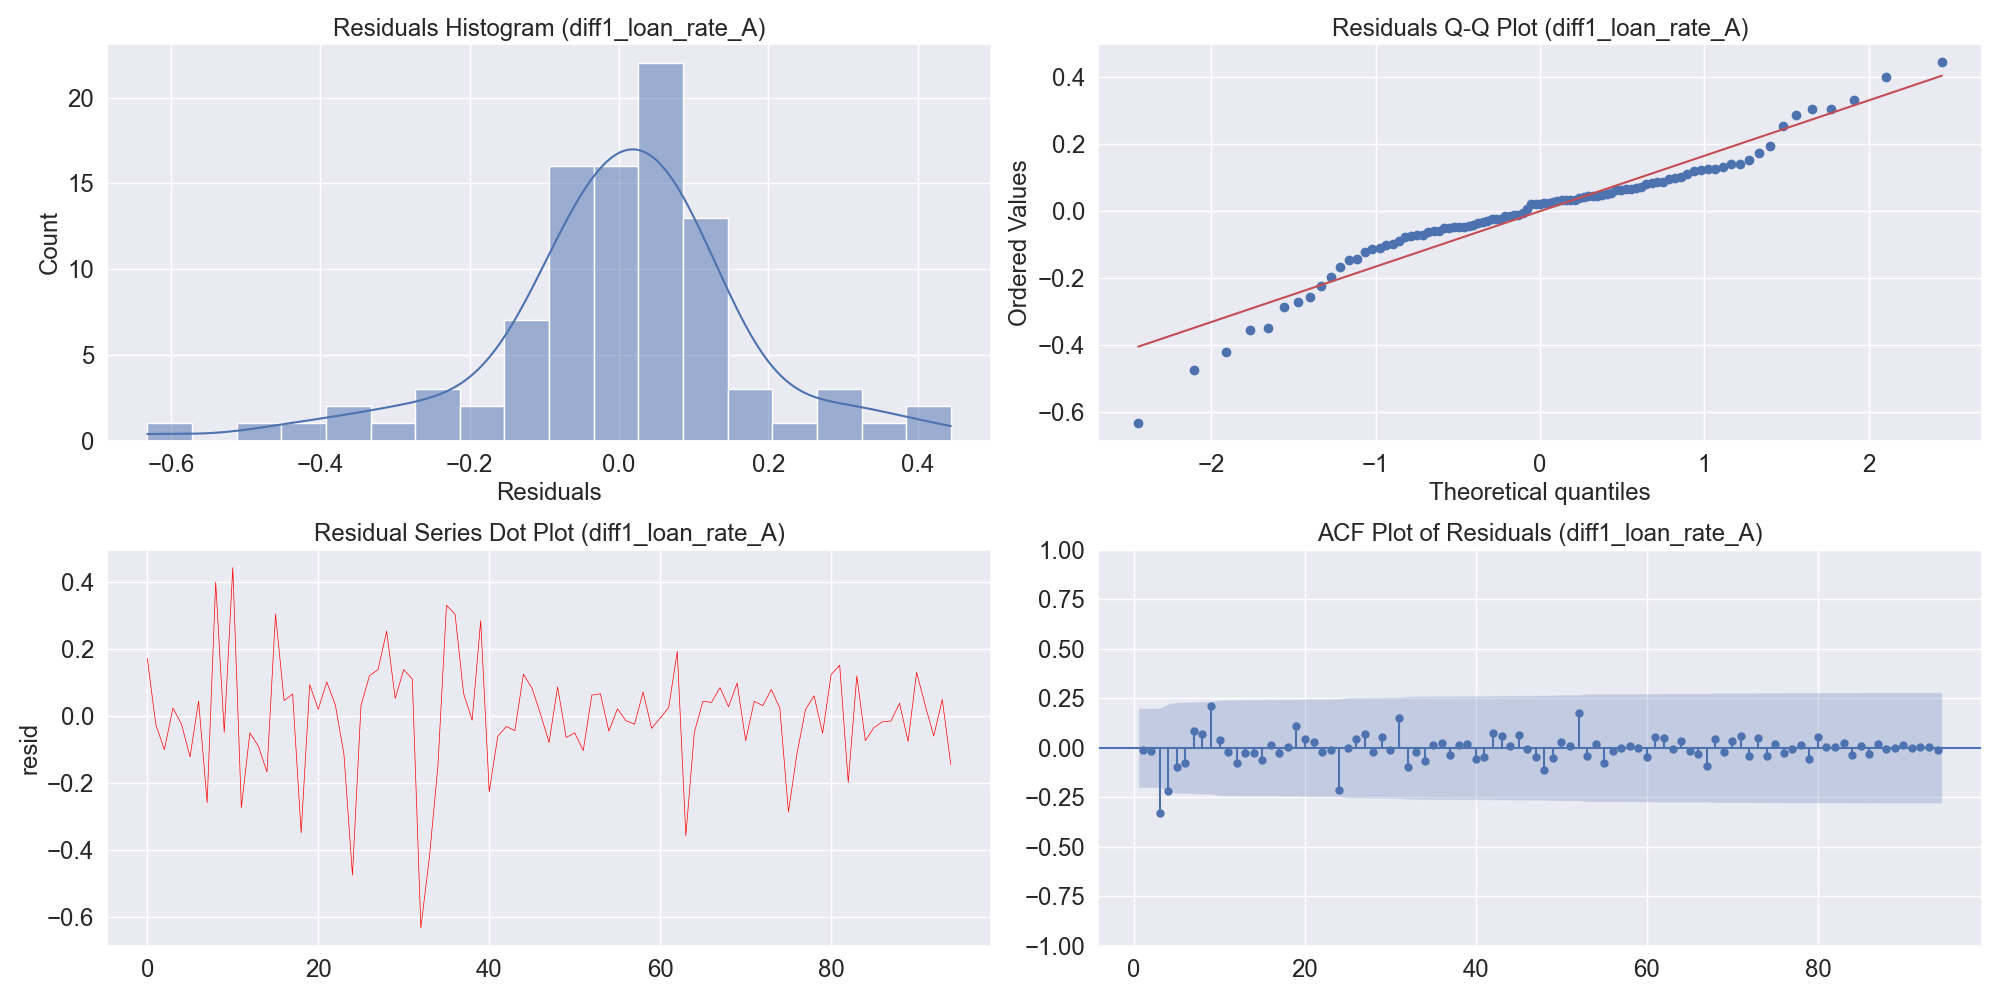
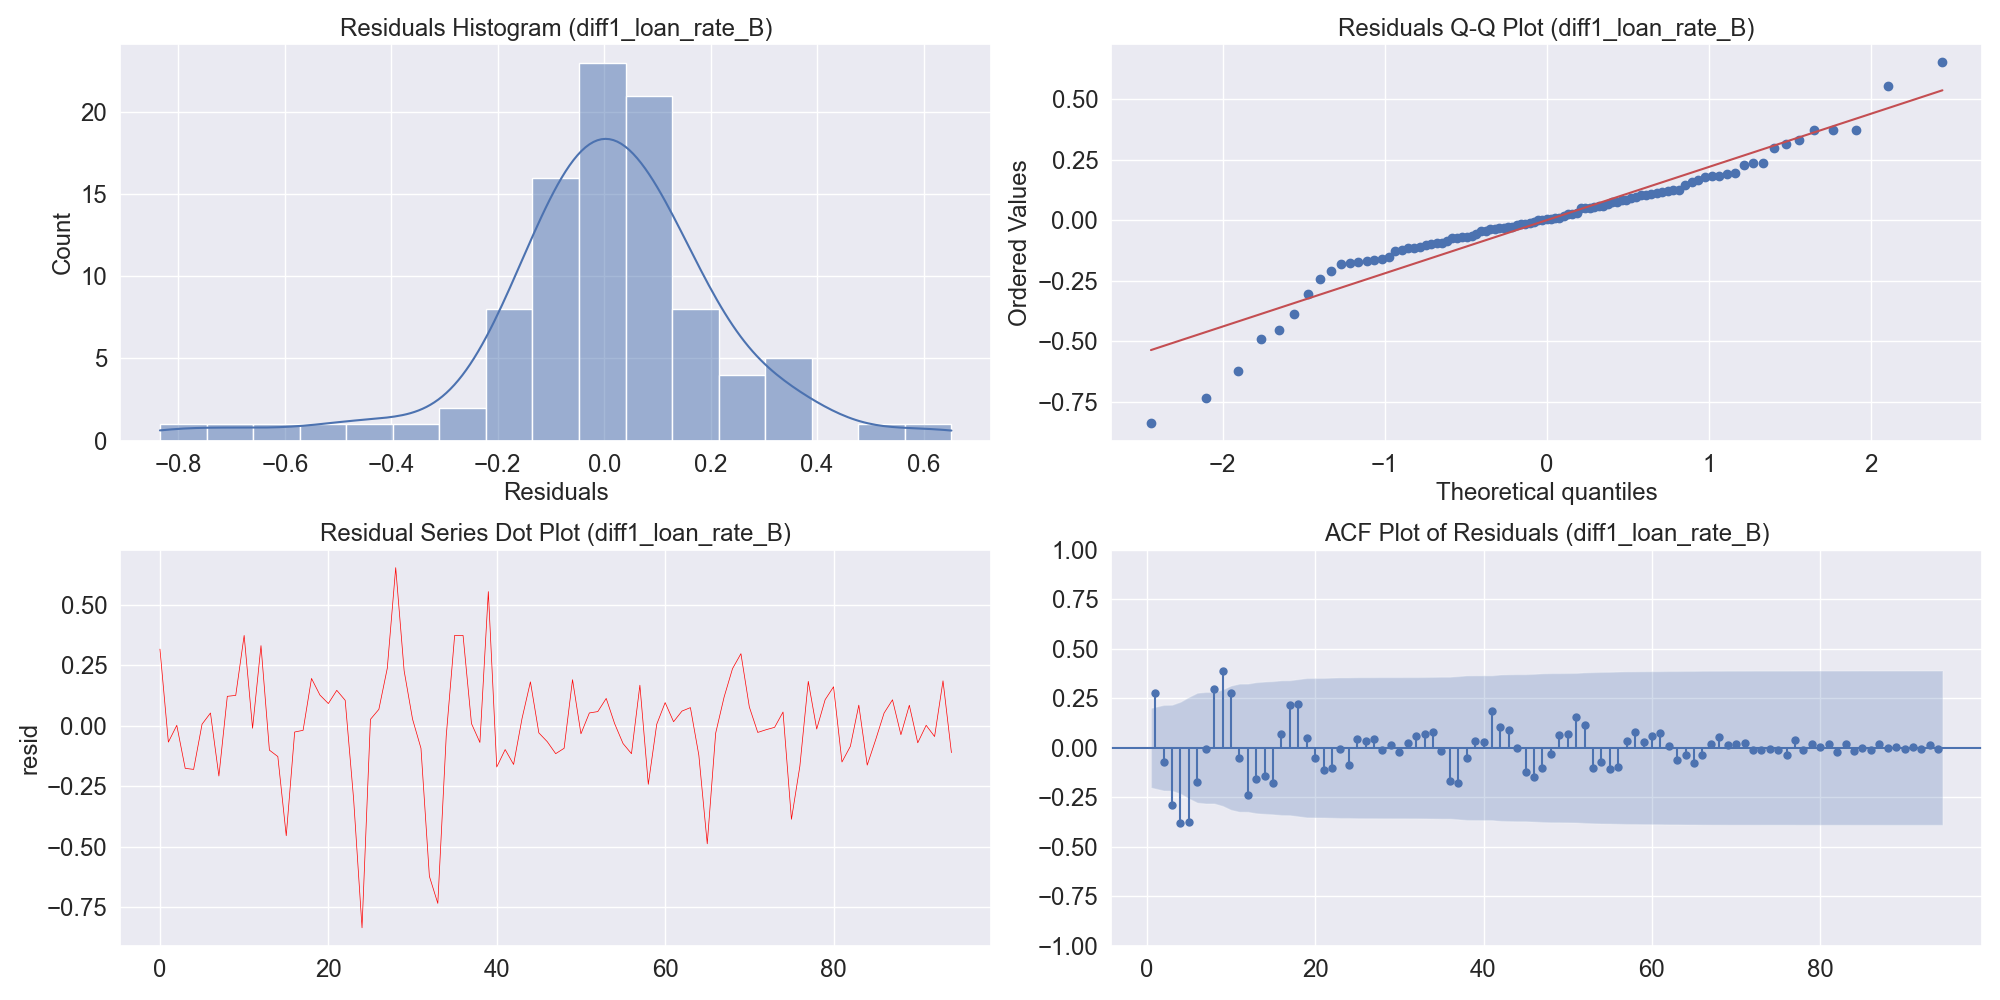
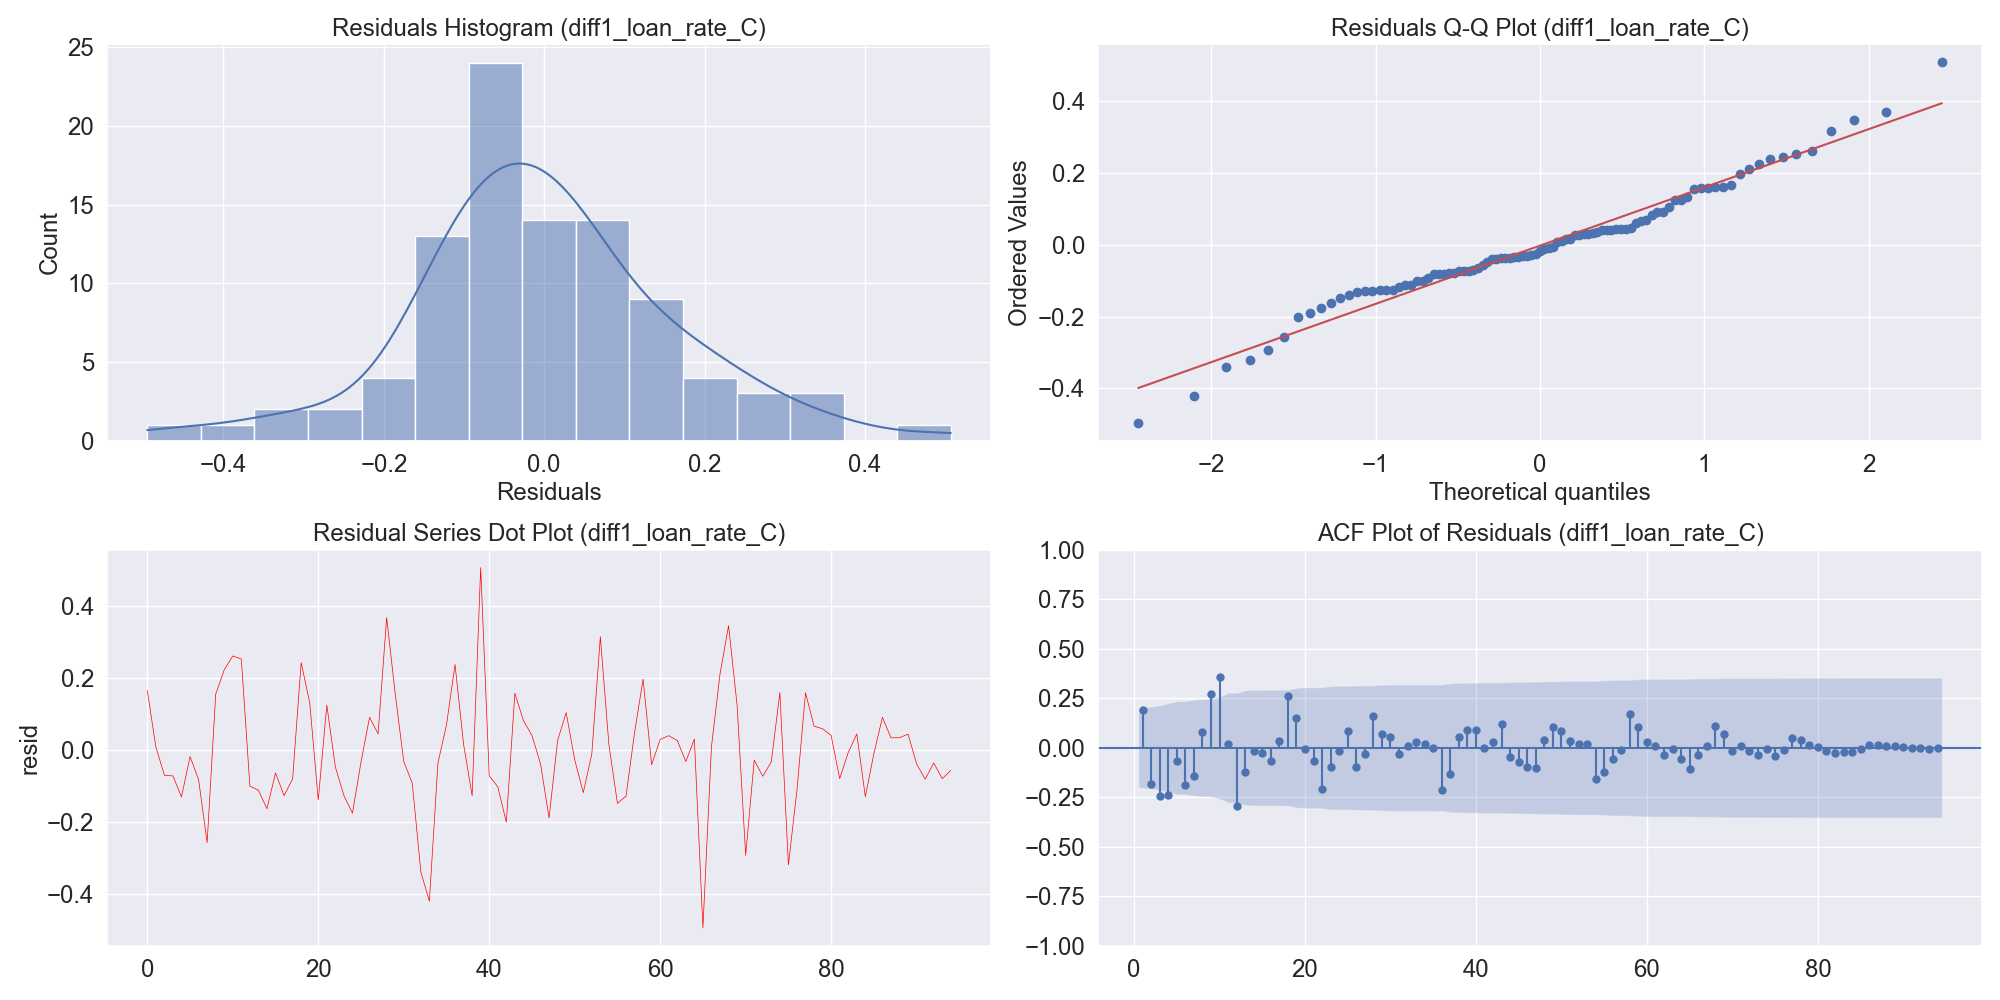
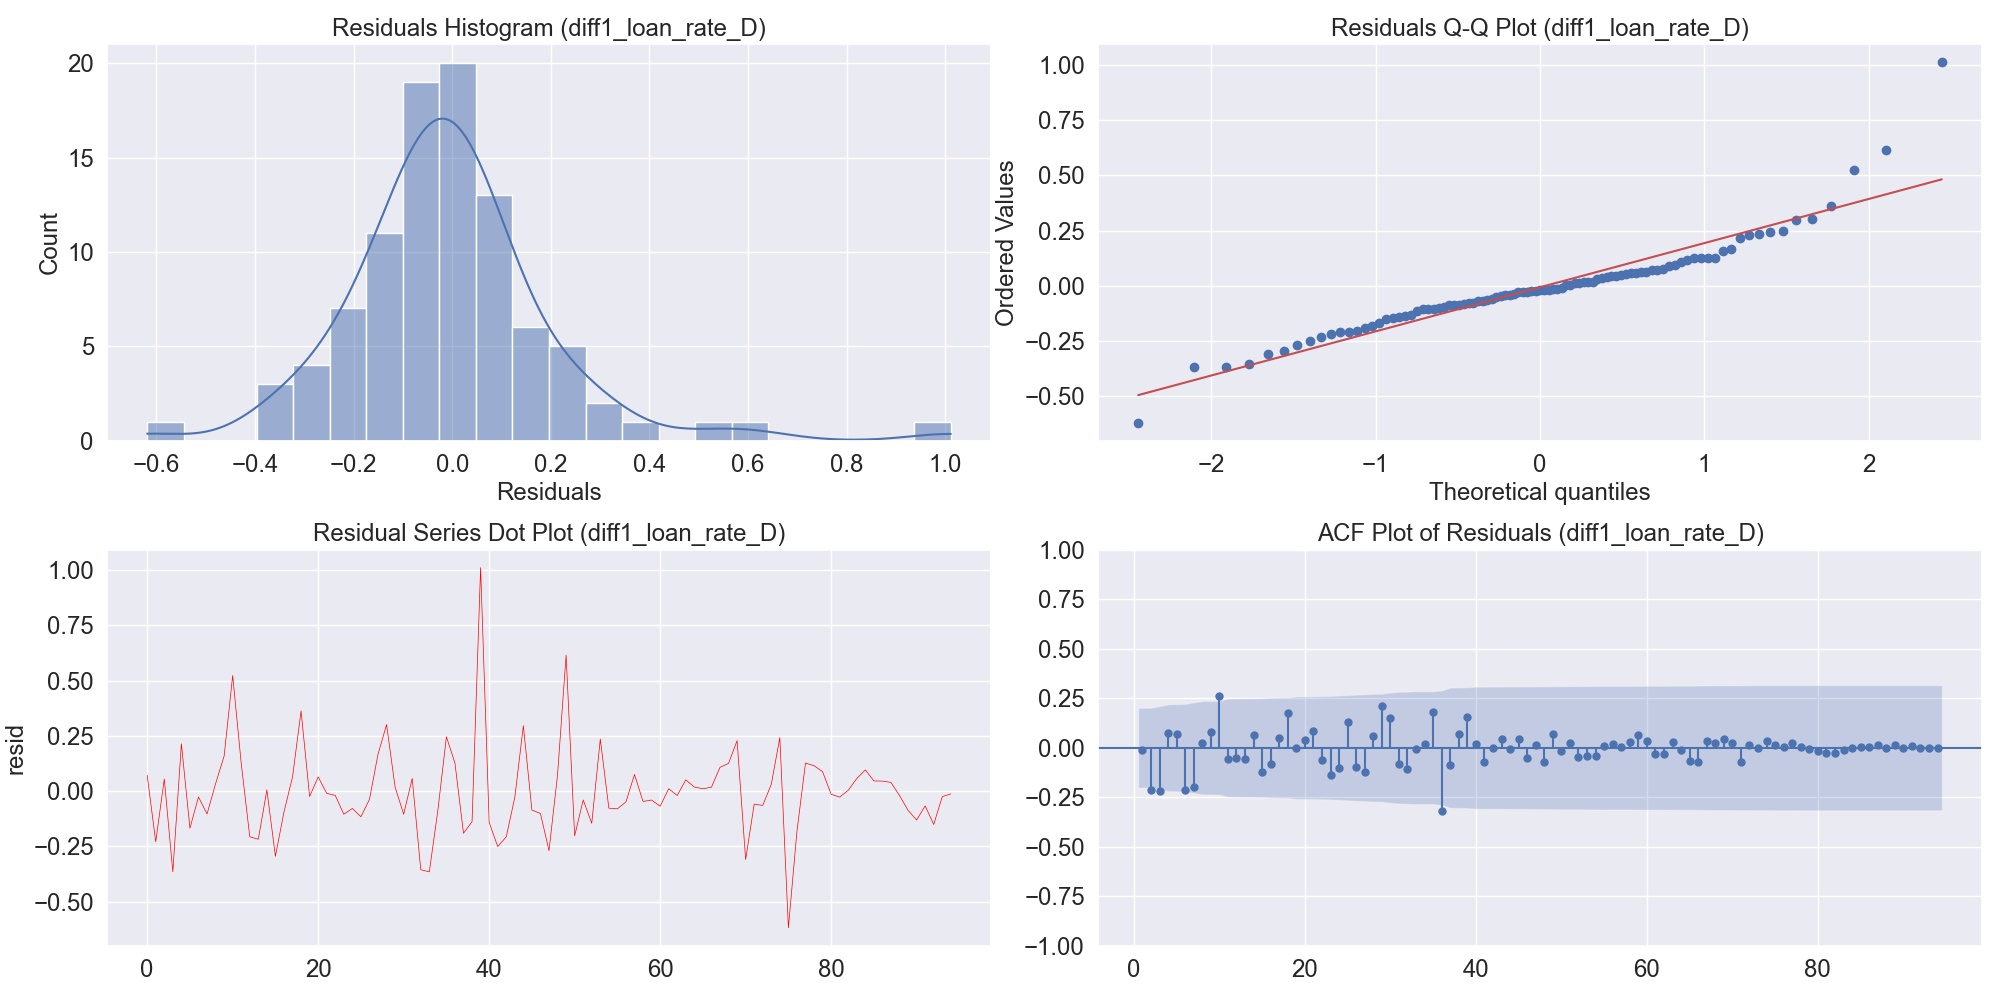
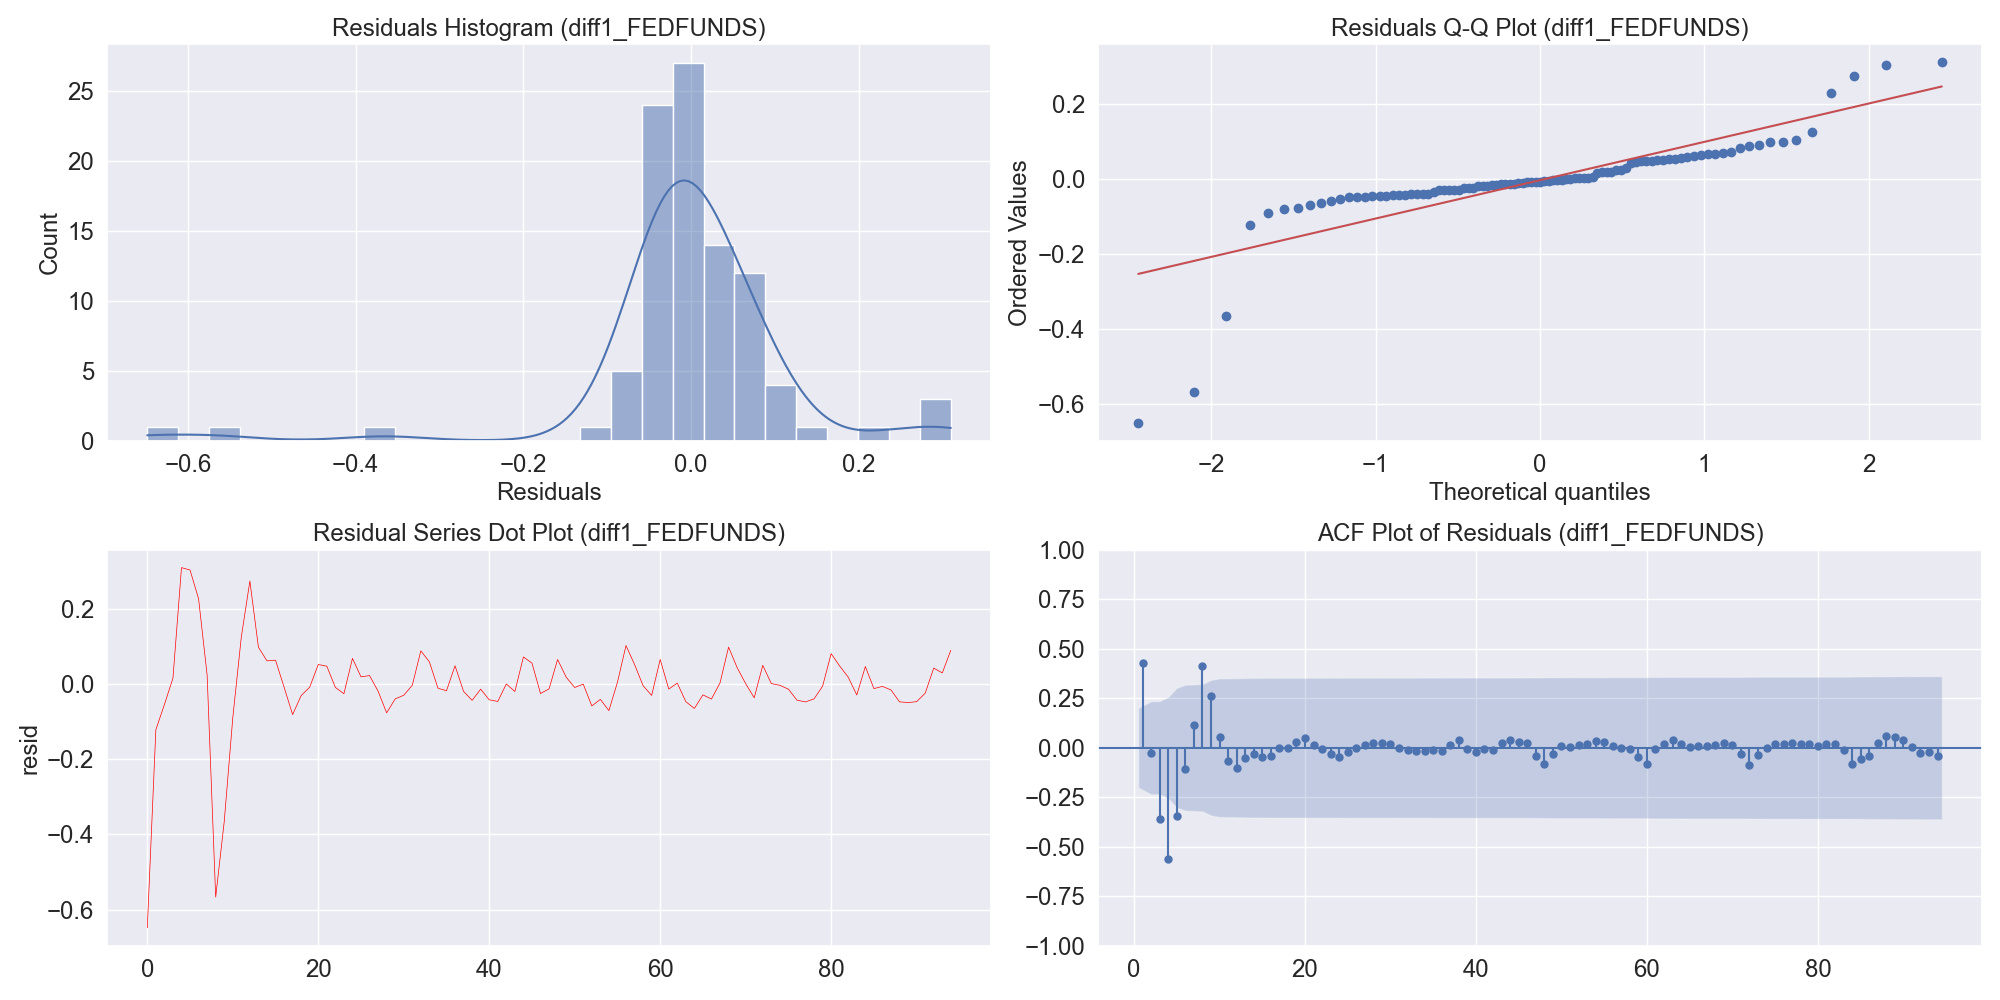
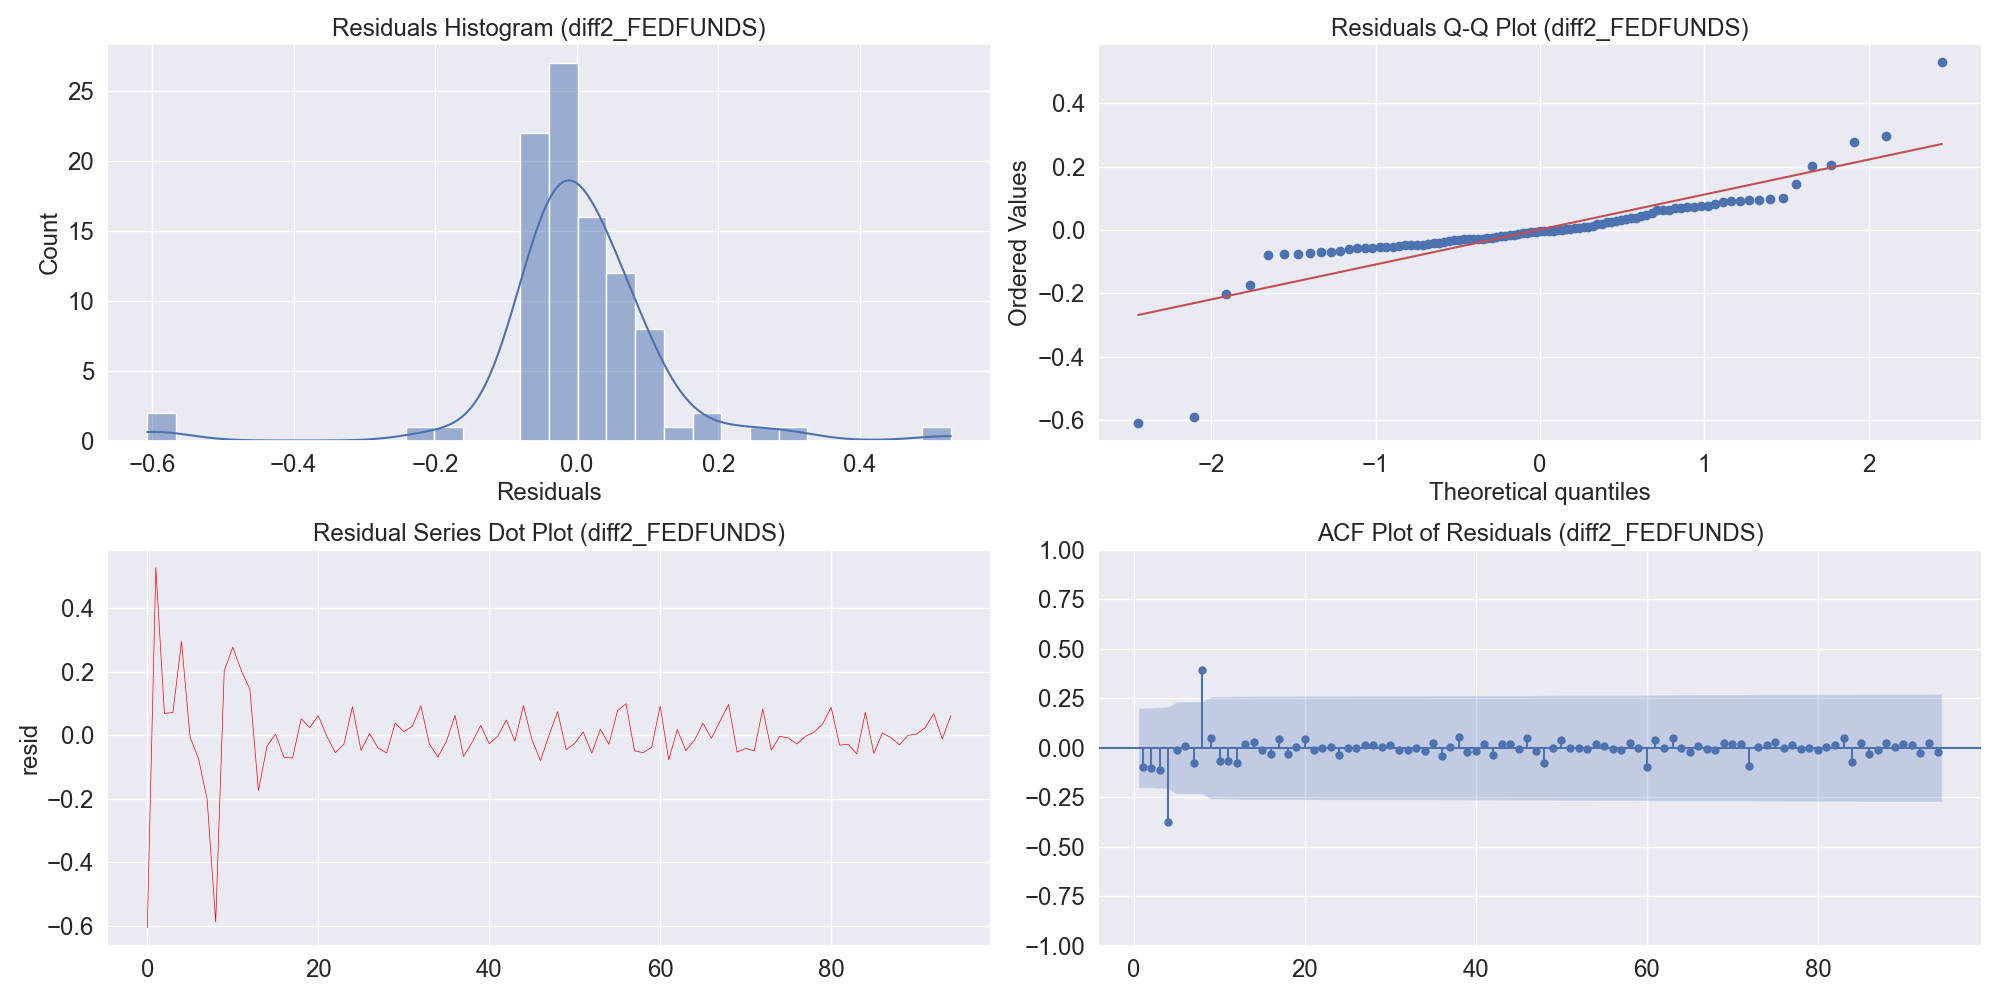

In [10]:
rvi_metric.result.show()

Test if Residuals are Normaly Distributed.

In [11]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

Test if Residuals are Autocorrelated.

In [12]:
# Comment: How do I pass the residuals of seasonal decomponsition done before using SeasonalDecomposeMetricWithFigure?
vm.run_test_plan("autocorrelation_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Step 4: Test for seasonality using the Augmented Dickey-Fuller (ADF) test**

**Step 5: Analyze the seasonality test results**

**Step 6: Interpret the results**

**Step 7: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

 ## A. Feature Analysis

## A.1. Univariate Analysis

### Visual Inspection

## A.2 Multivariave Analysis

### Visual Inspection

## B. Variable Selection

### ARIMA Analysis

**Step 1: Identify the Integration order (Stationarity Analysis)**

Unit Root Tests. 

**Step 2: Identify the AR order**

**Step 3: Identify the MA order**

In [15]:
vm.run_test_plan("normality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

**Run `SeasonalDecomposeMetricWithFigure` Test**

In [16]:
test_context = TestContext(train_ds=vm_train_ds)
sd_metric = SeasonalDecomposeMetricWithFigure(test_context=test_context)
sd_metric.run()

TestPlanMetricResult(figures=[Figure(key='seasonal_decomposition_with_figure', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=MetricResult(type='evaluation', scope='', key='seasonal_decomposition_with_figure', value={'loan_rate_A': [{'date': '2007-08-01', 'trend': nan, 'seasonal': -0.050284773390468294, 'resid': nan, 'observed': 7.7666666666666675}, {'date': '2007-09-01', 'trend': nan, 'seasonal': -0.06087962072801919, 'resid': nan, 'observed': 7.841428571428572}, {'date': '2007-10-01', 'trend': nan, 'seasonal': 0.01749661199350142, 'resid': nan, 'observed': 7.83}, {'date': '2007-11-01', 'trend': nan, 'seasonal': -0.047258378330469496, 'resid': nan, 'observed': 7.779090909090908}, {'date': '2007-12-01', 'trend': nan, 'seasonal': 0.0850517814632488, 'resid': nan, 'observed': 7.695833333333333}, {'date': '2008-01-01', 'trend': nan, 'seasonal': 0.06564185816692857, 'resid': nan, 'observed': 7.961333333333333}, {'date': '2008-02-01', 'trend': 8.0050487679590

**Run `ResidualsVisualInspection` Test**

In [17]:
test_context = TestContext(train_ds=vm_train_ds, test_ds=vm_test_ds)
rvi_test = ResidualsVisualInspection(test_context=test_context)
rvi_test.run()

TestPlanMetricResult(figures=[Figure(key='residuals_visual_inspection', metadata={}, figure=<Figure size 2000x1000 with 4 Axes>, extras=None)], metric=None)

In [18]:
vm.run_test_plan("seasonality_test_plan", train_ds=vm_train_ds, test_ds=vm_test_ds)

In [ ]:
vm.run_test_plan("timeseries_test_plan", test_ds=vm_test_ds, train_ds=vm_train_ds)